In [258]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 

### Modelo con asimetría de información

$$\begin{equation}
    \begin{aligned}
        \Gamma_{t}=\sum_{s=t}^{T}[U(c_{s}, g_{s}) + V(k_{s}) + \eta_{s}]\beta^{s-t}
    \end{aligned}
    \end{equation}$$

$$c_{t} = y - \tau_{t}$$
$$g_{t} +k_{t+1} = \tau_{t} + \epsilon_{t}$$

El votante representativo se preocupa por el valor esperado de su función de utilidad  $\mathbb{E}_{t}^{P}(\Gamma_{t})$

<ul>
    <li>c representa el consumo del bien privado por parte de un ciudadano representativo.</li>
    <li>g es el consumo del bien público (per cápita)</li>
    <li>k es la inversión pública (per cápita)</li>
</ul>

$$\begin{equation}
    \begin{aligned}
        W(g, \tau, \epsilon)=U(y-\tau, g) + \beta V(\tau + \epsilon - g)
    \end{aligned}
    \end{equation}$$

Si los votantes observan el último shock de competencia del incumbente antes de votar $\alpha_{i}$, entonces las expectativas hacia el incumbente serian.
$$ \mathbf{E}_{t}^{P}[W^{*}(\epsilon_{t+1})|\alpha_{t}=\alpha^{i}]=\Omega^{i}$$
Donde $i=H, L$ para los tipos compententes y no competentes en un modelo de senalizacion 

Para el caso del oponente, no se observa cuan competente es, entonces:
$$\mathbf{E}_{t}^{P}[W^{*}(\epsilon_{t+1}^{O})]=\Omega^{O}$$


El problema de maximizacion del incumbente de tipo $i=H, L$ seria:
$$\begin{equation}
    \begin{aligned}
        \max_{\tau, g} & \beta[X(1+\beta) + \Omega^{i}-\Omega^{O}]\pi[\hat{\rho}(g,\tau)]+ W(g, \tau, \epsilon^{i}) \\
        \text{sujeto a } & g, y- \tau, \tau + \epsilon^{i}-g \geq 0 \\
    \end{aligned}
    \end{equation}$$

Para la probabilidad de ganar elegimos una función que toma valores entre 0 y 1 con una relación positiva en g y una negativa en tau para reflejar las preferencias de los agentes por bajos impuestos y alto consumo público, al hacer esto le permitimos al agente manipular $\tau$ y $g$ pero al no modelar el valor esperado de la funcion de votos estariamos tambien quitandole cierta logica al agente racional que no estaria comparando sus utilidades esperadas con el incumbente y con el nuevo.

$$\begin{equation}
    \begin{aligned}
        \pi[\hat{\rho}(\tau, g)] = \mathbf{E}^{I}(v|g, \tau)
    \end{aligned}
    \end{equation}$$

Función de elección del líder

\begin{equation}
    v_{t} =
    \begin{cases}
        1 &  \text{si } \mathbf{E}_{t}^{P}(\Gamma_{t+1}) \geq \mathbf{E}_{t}^{P}(\Gamma_{t+1}^{O})\\
        0 & \text{en otro caso}\\
\end{cases}
\end{equation}

____________________

## Definiciones 

$$\begin{equation}
    \begin{aligned}
        \pi[\hat{\rho}(\tau, g)] = \frac{1}{1+e^{dg-h\tau-\eta_{t}^{i}}}
    \end{aligned}
    \end{equation}$$

Donde: $d$ y $h$ son valores positivos que controlan la sensibilidad de la funcion logistica elegida y $\eta$ es el shock de liderazgo no relacionado con la competencia, calibrar estos valores para reflejar la probabilidad de ganar del incumbente tambien sera un ejercicio clave que podria hacerse a traves de encuestas, la funcion $\Gamma$ debe ser utilizada para determinar la funcion de votacion comparando esas utilidades esperadas, solo de esa manera se inserta dentro la probabilidad, igual se podria usar esta probabilidad

$$ \epsilon_{t}^{i} = \alpha_{t}^{i} + \alpha_{t-1}^{i}$$
$$ \eta_{t}^{i} = q_{t}^{i} + q_{t-1}^{i}$$

$$U(c, g) = a \ln{c} + b\ln{g}$$
$$V(k) = -\ln{k}$$

### Parámetros

In [259]:
a, b = 1, 1     # constantes de la función de utilidad U
beta = 0.95     # Tasa de descuento intertemporal
X = 1           # Rentas de ego provenientes de ser líder

y = 10         # Producto en unidades de un bien no almacenable

T = 10          # Número máximo de periodos
t = 0           # Periodo inicial 

d = 1         # Elasticidad de la función logística para tau
h = 1         # Elasticidad de la función logística para g

### Calibración de variables aleatorias

Se eligen estos valores tanto para el incumbente como para su oponente

In [260]:
p = 0.3                 # Probabilidad de que el agente i sea competente en el periodo t
q_r = range(-10,10)     # Rango de valores donde viven los shocks de apariencia iguales para el incumbente y para el oponente

In [261]:
def genera_ar1(T, p):  # Se podría definir parámetros para los valores del proceso AR(1) y hacerlo más complejo
    # Valor inicial es una variable aleatoria
    series = np.random.binomial(1, p, T+1)

    return np.array(series)

def genera_ar2(T):  # Se podría definir parámetros para los valores del proceso AR(1) y hacerlo más complejo
    # Valor inicial es una variable aleatoria
    series = np.random.choice(q_r, T+1)

    return np.array(series)

In [262]:
# Generamos las series AR(1)
# Incumbente
alpha_series_i = genera_ar1(T, p)
q_series_i = genera_ar2(T)

# Oponente
alpha_series_o = genera_ar1(T, p)
q_series_o = genera_ar2(T)

In [263]:
# Calculamos epsilon y eta
# Incumbente
epsilon_ti = alpha_series_i[1:] + alpha_series_i[:-1]
eta_ti = q_series_i[1:] + q_series_i[:-1]

# Oponente
epsilon_to = alpha_series_o[1:] + alpha_series_o[:-1]
eta_to = q_series_o[1:] + q_series_o[:-1]

### Funciones

Definimos las funciones que vamos a usar 

$$\begin{equation}
    \begin{aligned}
        W(g, \tau, \epsilon)=U(y-\tau, g) + \beta V(\tau + \epsilon - g)
    \end{aligned}
    \end{equation}$$

In [264]:
def W(x, y, epsilon, beta, a, b):
    tau, g = x
    c = y - tau
    k = tau + epsilon - g
    return -(a * np.log(c) + b * np.log(g) + beta * (-np.log(k)))  # Negativo porque usamos un minimizador de scipy

$$\begin{equation}
    \begin{aligned}
        \Gamma_{t}=\sum_{s=t}^{T}[U(c_{s}, g_{s}) + V(k_{s}) + \eta_{s}]\beta^{s-t}
    \end{aligned}
    \end{equation}$$

In [265]:
def gamma(x, y, eta, beta, epsilon, t, T, a, b):
    tau, g = x
    c = y - tau
    k = tau + epsilon - g
    return sum([(a * np.log(c) + b * np.log(g) + (-np.log(k[s])) + eta[s])*beta**(s-t) for s in range(t, T)])

$$\begin{equation}
    \begin{aligned}
        \pi[\hat{\rho}(\tau, g)] = \frac{1}{1+e^{dg-h\tau-\eta_{t}^{i}}}
    \end{aligned}
    \end{equation}$$

In [266]:
def pi(x, d, h, eta_i):
    tau, g = x
    return 1/(1+np.exp(d*g-h*tau-eta_i))

Definimos una función que optimiza la función W para cada periodo de tiempo, ya que será usada como insumo en la función principal del modelo

$$\begin{equation}
    \begin{aligned}
        \mathbf{E}_{t}^{P}[W^{*}(\epsilon_{t+1})|\alpha_{t}=\alpha^{i}]=\Omega^{i}
        \end{aligned}
    \end{equation}$$
Con $i=H, L$ para los tipos con alta competencia o baja competencia respectivamente

$$\begin{equation}
    \begin{aligned}
        \mathbf{E}_{t}^{P}[W^{*}(\epsilon_{t+1}^{O})]=\Omega^{O}
        \end{aligned}
    \end{equation}$$

Donde $W^{*}(\epsilon)=W^{*}[g^{*}(\epsilon), \tau^{*}(\epsilon), \epsilon]$ viene de resolver
$$\begin{equation}
    \begin{aligned}
        \max_{\tau, g} & \beta[X(1+\beta) + \Omega^{i}-\Omega^{O}]\pi[\hat{\rho}(g,\tau)]+ W(g, \tau, \epsilon^{i}) \\
        \text{sujeto a } & g, y- \tau, \tau + \epsilon^{i}-g \geq 0 \\
    \end{aligned}
    \end{equation}$$

Para la maximización que el optimizador de scipy lo resuelve iterando la función de valor debemos proporcionar un valor inicial

In [267]:
# Guess inicial (Por ahora tau y g empiezan tomando valores en la mitad de su rango permitido)
x0 = [y/2, y/4]

Restricciones

In [268]:
def constraint1(x, y):
    # y - tau >= 0
    return y - x[0]

def constraint2(x):
    # g >= 0
    return x[1]

def constraint3(x, epsilon):
    # tau + epsilon - g >= 0
    return x[0] + epsilon - x[1]

In [269]:
def optimizador_W(T, y, beta, a, b, epsilon):
    tau_optimo = []
    g_optimo = []
    valores_max = []

    for t in range(T):
        # Itera sobre los valores de competencia del agente
        epsilon_t = epsilon[t]

        # Restricciones por cada periodo de tiempo(epsilon)
        con1 = {'type': 'ineq', 'fun': constraint1, 'args': (y,)}
        con2 = {'type': 'ineq', 'fun': constraint2}
        con3 = {'type': 'ineq', 'fun': constraint3, 'args': (epsilon_t,)}

        # Combinamos las restricciones en una lista
        constraints_t = [con1, con2, con3]

        # Optimiza para ese periodo de tiempo t
        resultado_t = minimize(W, x0, args=(y, epsilon_t, beta, a, b), constraints=constraints_t)

        # Guarda los resultados para cada periodo de tiempo
        tau_optimo.append(resultado_t.x[0])
        g_optimo.append(resultado_t.x[1])
        valores_max.append(resultado_t.fun)

    return tau_optimo, g_optimo, valores_max

Estimacion bayesiana de los valores de Omega

In [270]:
# Solo para el incumbente, porque no podemos condicionar para el oponente, usamos solo una implementación rudimentaria de la teoría bayesiana
# valor a priori
p_prior = 0.3

# Generamos alpha prior
alpha_prior = genera_ar1(T, p_prior)

# Buscamos actualizamos p con los valores observados de epsilon_ti, expectativas adaptativas asumiendo que epsilon_ti es el valor observado
# Esto es una versión simplificada ya que se podrían usar métodos numéricos
mu_observado = np.mean(alpha_prior)
sigma_observado = np.std(alpha_prior) / np.sqrt(len(alpha_prior))

p_posterior = 1 - sigma_observado/mu_observado  # según una distribución binomial

# Update sigma's prior similarly (this is also simplified)
# sigma_mu_posterior = np.std(observed_epsilon)
# sigma_sigma_posterior = np.std(observed_epsilon) / np.sqrt(len(observed_epsilon))

# Simulate future values of epsilon
alpha_simulado = genera_ar1(T, p_posterior)
epsilon_simulado = alpha_simulado[1:] + alpha_simulado[:-1]

In [271]:
def constraint1(x, y):
    # y - tau >= 0
    return y - x[0]

def constraint2(x):
    # g >= 0
    return x[1]

def constraint3(x, epsilon):
    # tau + epsilon - g >= 0
    return x[0] + epsilon - x[1]

In [272]:
def optimizador_W(T, y, beta, a, b, epsilon):
    tau_optimo = []
    g_optimo = []
    valores_max = []

    for t in range(T):
        # Itera sobre los valores de competencia del agente
        epsilon_t = epsilon[t]

        # Restricciones por cada periodo de tiempo(epsilon)
        con1 = {'type': 'ineq', 'fun': constraint1, 'args': (y,)}
        con2 = {'type': 'ineq', 'fun': constraint2}
        con3 = {'type': 'ineq', 'fun': constraint3, 'args': (epsilon_t,)}

        # Combinamos las restricciones en una lista
        constraints_t = [con1, con2, con3]

        # Optimiza para ese periodo de tiempo t
        resultado_t = minimize(W, x0, args=(y, epsilon_t, beta, a, b), constraints=constraints_t)

        # Guarda los resultados para cada periodo de tiempo
        tau_optimo.append(resultado_t.x[0])
        g_optimo.append(resultado_t.x[1])
        valores_max.append(resultado_t.fun)

    return tau_optimo, g_optimo, valores_max

In [273]:
# Calculamos los Omega como el valor esperado de la maximización de W considerando los diferentes epsilon
# Para Omega_i
for epsilon in epsilon_simulado:  # Optimiza Omega con los epsilon conditionados en el valor a priori
    _, _, u_i = optimizador_W(T, y, beta, a, b, epsilon_simulado)

Omega_i = np.mean(u_i) # valor esperado

# Para Omega_O 
for epsilon in epsilon_to:  # With the real oponents stochastic values, we can't dondition opponent values
    _, _, u_o = optimizador_W(T, y, beta, a, b, epsilon_to)

Omega_o = np.mean(u_o) # Expected value

C:\Users\oscar\AppData\Local\Temp\ipykernel_2752\4070151217.py:5: RuntimeWarning: invalid value encountered in log
  return -(a * np.log(c) + b * np.log(g) + beta * (-np.log(k)))  # Negativo porque usamos un minimizador de scipy


Ahora si definimos la función del modelo con asimetría de información

In [274]:
def asimetria(x, X, beta, y, a, b, epsilon_ti, Omega_i, Omega_o, d, h, eta_ti):
    valor_pi = pi(x, d, h, eta_ti[t])  
    w_i = W(x, y, epsilon_ti[t], beta, a, b) # epsilon_[t] considera la realización de competencia real en el momento de la elección

    return -(beta*(X*(1+beta) + Omega_i-Omega_o)*valor_pi + w_i) # Negativo para usar el minimizador de scipy

Resolvemos el problema de maximización del incumbente

In [276]:
# Argumentos para la función asimetria
args = (X, beta, y, a, b, epsilon_ti, Omega_i, Omega_o, d, h, eta_ti)

# Definición de restricciones
constraints = (
    {'type': 'ineq', 'fun': constraint1, 'args': (y,)},
    {'type': 'ineq', 'fun': constraint2},
    {'type': 'ineq', 'fun': constraint3, 'args': (epsilon_ti,)}  # Aquí epsilon_ti es un escalar
)

# Realizar la optimización
resultado = minimize(asimetria, x0, args=args, constraints=constraints)

# Resultados óptimos
tau_optimo, g_optimo = resultado.x

print("tau optimo", tau_optimo)
print("g optimo", g_optimo)

tau optimo 6.888653695761167
g optimo 6.394884621840902e-14


C:\Users\oscar\AppData\Local\Temp\ipykernel_2752\4070151217.py:5: RuntimeWarning: invalid value encountered in log
  return -(a * np.log(c) + b * np.log(g) + beta * (-np.log(k)))  # Negativo porque usamos un minimizador de scipy


___________________________

### Equilibrios Secuenciales

In [277]:
def equilibrios_secuenciales(T, av, X, beta, y, a, b, epsilon_ti, Omega_i, Omega_o, d, h, eta_ti):
    periodos = range(T)
    elecciones = [1 if i % av == 0 else 0 for i in range(T)]
    tau_seq = []
    g_seq = []


    for t in periodos:
        # En periodos no electorales elecciones == 0
        if elecciones[t] == 0:
            # Itera sobre los valores de competencia del agente
            epsilon_t = epsilon_ti[t]

            # Restricciones por cada periodo de tiempo(epsilon)
            con1 = {'type': 'ineq', 'fun': constraint1, 'args': (y,)}
            con2 = {'type': 'ineq', 'fun': constraint2}
            con3 = {'type': 'ineq', 'fun': constraint3, 'args': (epsilon_t,)}

            # Combinamos las restricciones en una lista
            constraints_t = [con1, con2, con3]

            # Optimizacion en un periodo no electoral
            resultado_t = minimize(W, x0, args=(y, epsilon_t, beta, a, b), constraints=constraints_t)

            # Guarda los resultados para cada periodo de tiempo
            tau_seq.append(resultado_t.x[0])
            g_seq.append(resultado_t.x[1])

            print("Epsilon incumbente: ", epsilon_t)
        
        # En periodos electorales elecciones == 1
        else:
            # Argumentos para la función asimetria
            args = (X, beta, y, a, b, epsilon_ti, Omega_i, Omega_o, d, h, eta_ti)

            # Definición de restricciones
            constraints = (
                {'type': 'ineq', 'fun': constraint1, 'args': (y,)},
                {'type': 'ineq', 'fun': constraint2},
                {'type': 'ineq', 'fun': constraint3, 'args': (epsilon_ti,)}  # Aquí epsilon_i es un escalar
            )

            # Realizar la optimización
            resultado_t = minimize(asimetria, x0, args=args, constraints=constraints)

            # Guarda los resultados para cada periodo de tiempo
            tau_seq.append(resultado_t.x[0])
            g_seq.append(resultado_t.x[1])

            print("Epsilon incumbente: ", epsilon_ti[t])
            print("Epsilon oponente: ", epsilon_to[t])
          
    return tau_seq, g_seq, elecciones


In [280]:
equilibrios_secuenciales(T, 2, X, beta, y, a, b, epsilon_ti, Omega_i, Omega_o, d, h, eta_ti)

Epsilon incumbente:  2
Epsilon oponente:  1
Epsilon incumbente:  1
Epsilon incumbente:  0
Epsilon oponente:  1
Epsilon incumbente:  0
Epsilon incumbente:  0
Epsilon oponente:  2
Epsilon incumbente:  0
Epsilon incumbente:  0
Epsilon oponente:  0
Epsilon incumbente:  0
Epsilon incumbente:  1
Epsilon oponente:  0
Epsilon incumbente:  1


C:\Users\oscar\AppData\Local\Temp\ipykernel_2752\4070151217.py:5: RuntimeWarning: invalid value encountered in log
  return -(a * np.log(c) + b * np.log(g) + beta * (-np.log(k)))  # Negativo porque usamos un minimizador de scipy


([6.888653695761167,
  3.52338844241996,
  6.888653695761167,
  4.069832116307562,
  6.888653695761167,
  4.069832116307562,
  6.888653695761167,
  4.069832116307562,
  6.888653695761167,
  3.52338844241996],
 [6.394884621840902e-14,
  4.523388442409436,
  6.394884621840902e-14,
  4.069818283282571,
  6.394884621840902e-14,
  4.069818283282571,
  6.394884621840902e-14,
  4.069818283282571,
  6.394884621840902e-14,
  4.523388442409436],
 [1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

## Gráficos

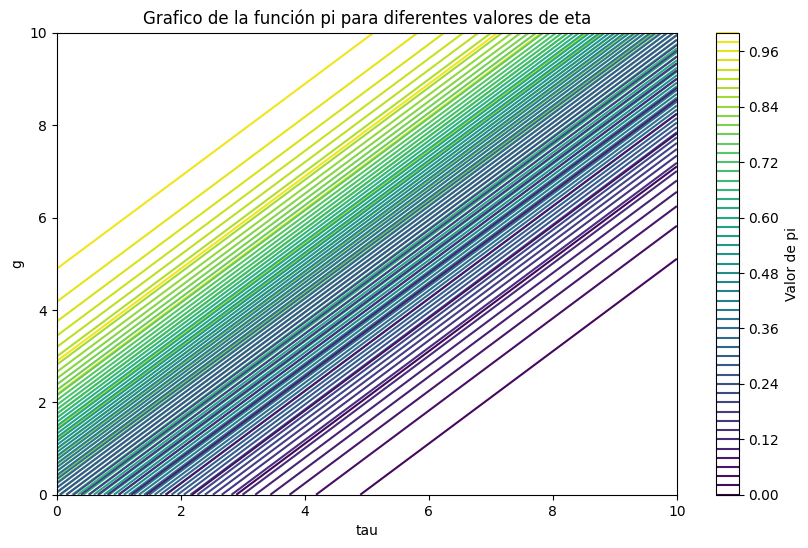

In [167]:
# Definición de la función pi
def pi(x, d, h, eta_i):
    tau, g = x
    return 1 / (1 + np.exp(d * g - h * tau - eta_i))

# Valores de d, h y un rango de tau y g para graficar
d = 1
h = 1
tau_range = np.linspace(0, 10, 100)
g_range = np.linspace(0, 10, 100)

# Valores de epsilon para probar
eta_values = [1, -1]

# Crear la gráfica
plt.figure(figsize=(10, 6))

for eta in eta_values:
    pi_values = [pi([tau, g], d, h, eta) for tau in tau_range for g in g_range]
    pi_matrix = np.reshape(pi_values, (len(tau_range), len(g_range)))
    plt.contour(tau_range, g_range, pi_matrix, levels=50, cmap='viridis')

plt.title("Grafico de la función pi para diferentes valores de eta")
plt.xlabel("tau")
plt.ylabel("g")
plt.colorbar(label="Valor de pi")
plt.show()

C:\Users\oscar\AppData\Local\Temp\ipykernel_6600\2496155234.py:31: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(tau_range, g_range, W_matrix, levels=20, cmap='viridis', label=f"Epsilon = {epsilon}")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


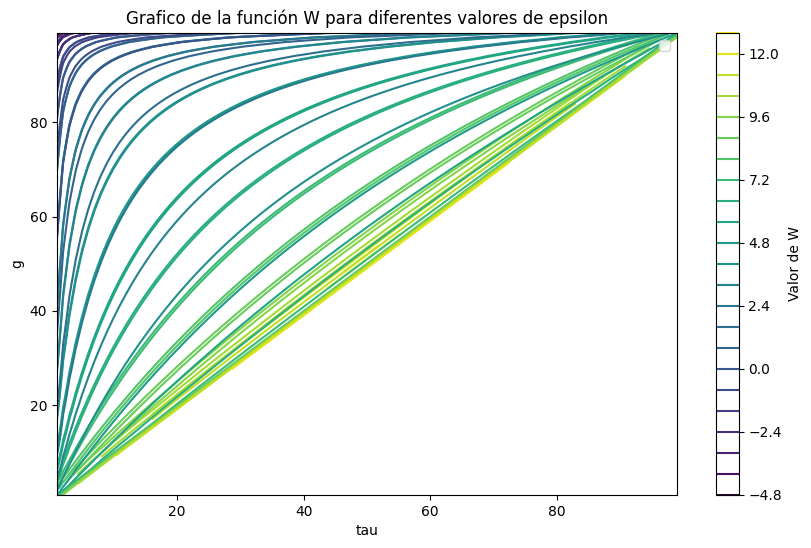

In [162]:
# Definición de la función W
def W(x, y, epsilon, beta, a, b):
    tau, g = x
    c = y - tau
    k = tau + epsilon - g
    # Asegurarse de que c, g, y k sean mayores que 0 para evitar errores con np.log
    if c <= 0 or g <= 0 or k <= 0:
        return np.inf
    return (a * np.log(c) + b * np.log(g) + beta * (-np.log(k)))

# Parámetros
y = 100
beta = 0.95
a = 1
b = 1

# Rango de valores para tau y g
tau_range = np.linspace(1, 99, 100)
g_range = np.linspace(1, 99, 100)

# Valores de epsilon para probar
epsilon_values = [-1, 0, 1]

# Preparar la gráfica
plt.figure(figsize=(10, 6))

# Graficar la función para diferentes valores de epsilon
for epsilon in epsilon_values:
    W_values = np.array([W([tau, g], y, epsilon, beta, a, b) for tau in tau_range for g in g_range])
    W_matrix = W_values.reshape(len(tau_range), len(g_range))
    plt.contour(tau_range, g_range, W_matrix, levels=20, cmap='viridis', label=f"Epsilon = {epsilon}")

plt.title("Grafico de la función W para diferentes valores de epsilon")
plt.xlabel("tau")
plt.ylabel("g")
plt.colorbar(label="Valor de W")
plt.legend()
plt.show()

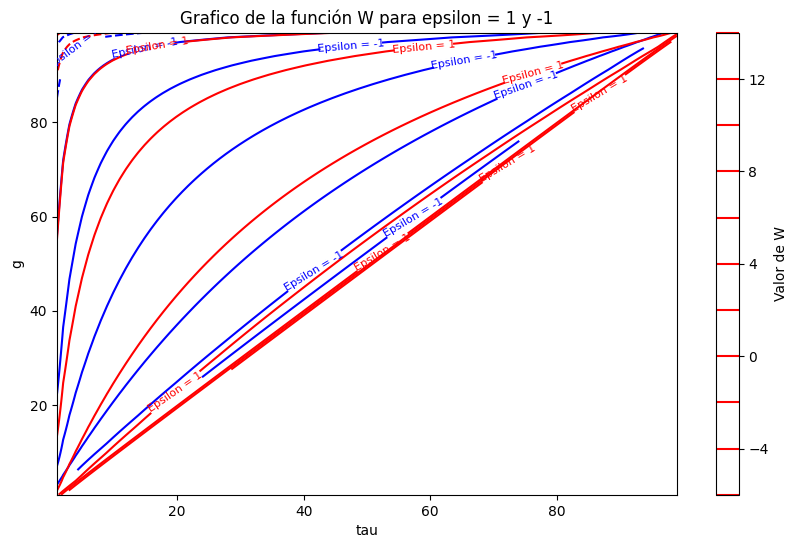

In [168]:
# Redefinición del código para simplificar el gráfico con menos curvas y solo para epsilon 1 y -1

# Parámetros
y = 100
beta = 0.95
a = 1
b = 1

# Rango de valores para tau y g
tau_range = np.linspace(1, 99, 100)
g_range = np.linspace(1, 99, 100)

# Valores de epsilon para probar
epsilon_values = [-1, 1]

# Preparar la gráfica
plt.figure(figsize=(10, 6))

# Crear colores para cada valor de epsilon
colors = ['blue', 'red']

# Graficar la función para los valores de epsilon seleccionados
for epsilon, color in zip(epsilon_values, colors):
    W_values = np.array([W([tau, g], y, epsilon, beta, a, b) for tau in tau_range for g in g_range])
    W_matrix = W_values.reshape(len(tau_range), len(g_range))
    CS = plt.contour(tau_range, g_range, W_matrix, levels=10, colors=color)
    plt.clabel(CS, inline=1, fontsize=8, fmt=f'Epsilon = {epsilon}')

plt.title("Grafico de la función W para epsilon = 1 y -1")
plt.xlabel("tau")
plt.ylabel("g")
plt.colorbar(label="Valor de W")
plt.show()

